In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Data Processing
## Todo List
1. Calculate running totals and average wins/loses
2. Generate Plots
3. Assign skill scores
4. Create betting metrics/odds
5. Easy data entry mode

In [117]:
df_data = pd.read_csv("data.csv")
guests = ['oscar','nick','drew','ruohan','brandon','lixin','alice']
big3 = ['connor','helio','sam']
#Add a guest column
df_data['guest']= df_data[guests].sum(axis=1, min_count=1)
players = big3+guests+['guest']
df = df_data[players].fillna(0).cumsum()

# Mask non-played games to prevent graphing
df = df.mask(df_data[players].isna())

# Add a starting row at index -1 with all zeros to ensure graphs start at 0
start_row = pd.Series(0, index=players, name=-1)
df = pd.concat([pd.DataFrame([start_row]), df]).sort_index()

# For all players, ensure there's a connection from 0 to their first game
for p in players:
    first_idx = df_data[p].first_valid_index()
    if first_idx is not None and first_idx > 0:
        df.loc[first_idx - 1, p] = 0

#Convert to Dollars
df = df/100
#df.to_csv("results.csv", index = False)

## Some Basic Plots
We start with the net profit loss chart. 

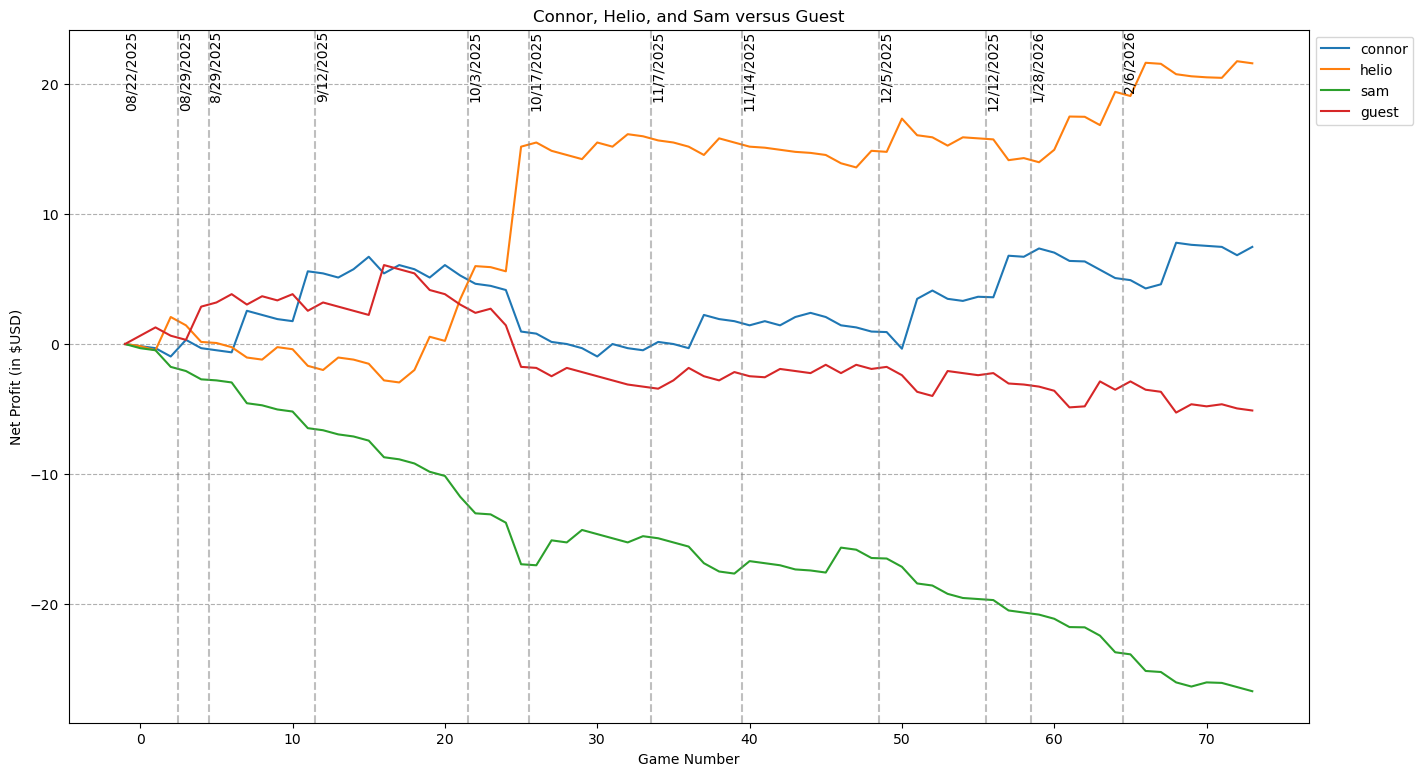

In [118]:
ax1 = df[big3+['guest']].plot(figsize=(16, 9))
ax1.set_title('Connor, Helio, and Sam versus Guest')

# Vertical bars for days with labels
y_min, y_max = ax1.get_ylim()
date_changes = df_data.index[df_data['date'].ne(df_data['date'].shift())].tolist()
for i in date_changes:
    if i == 0:
        plt.text(-1, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)
    else:
        plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.5)
        plt.text(i-0.5, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)

# Horizontal lines
plt.grid(axis='y', linestyle='--')

plt.xlabel("Game Number")
plt.ylabel("Net Profit (in $USD)")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit.png", bbox_inches='tight')


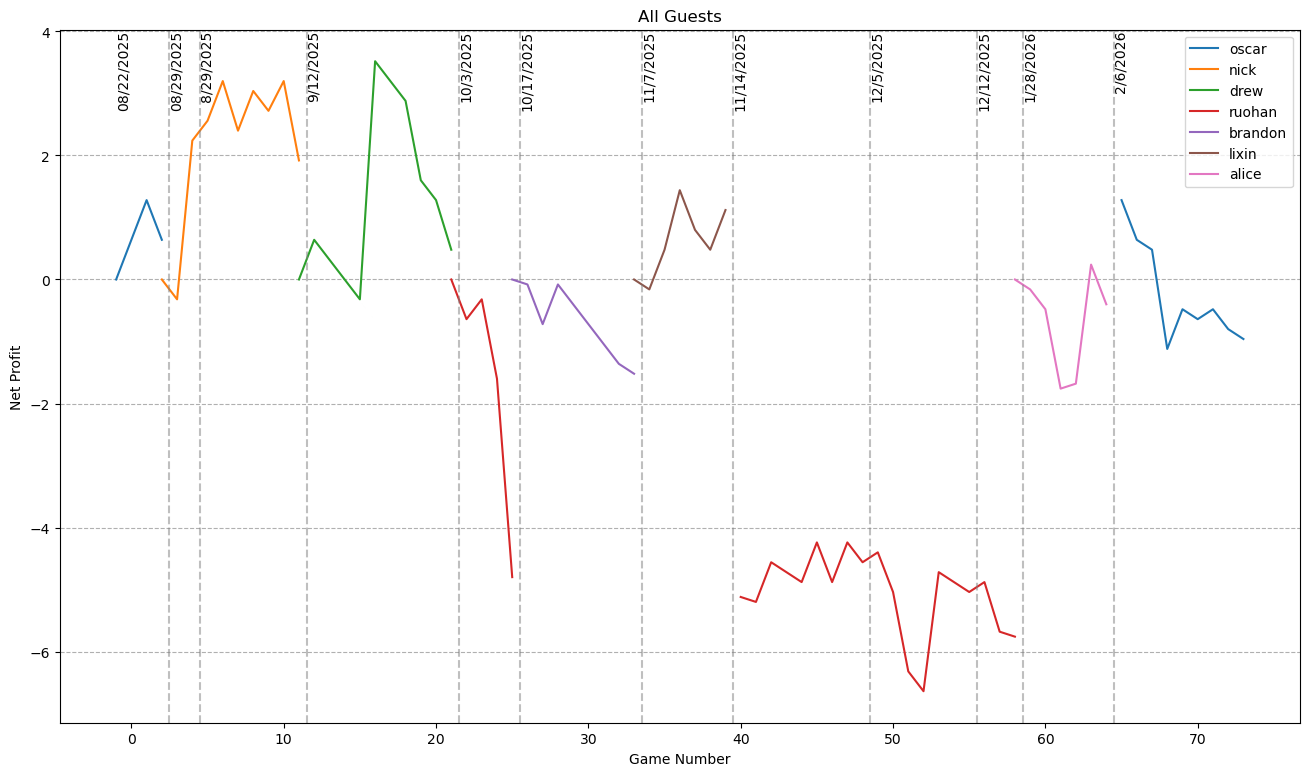

In [119]:

ax2 = df[guests].plot(figsize=(16, 9))
ax2.set_title('All Guests')

# Vertical bars for days with labels
y_min, y_max = ax2.get_ylim()
date_changes = df_data.index[df_data['date'].ne(df_data['date'].shift())].tolist()
for i in date_changes:
    if i == 0:
        plt.text(-1, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)
    else:
        plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.5)
        plt.text(i-0.5, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)

# Horizontal lines
plt.grid(axis='y', linestyle='--')

plt.xlabel("Game Number")
plt.ylabel("Net Profit")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit_guests.png", bbox_inches="tight")


## Autocorrelation Plots
An autocorrelogram shows that there appears to be a self correlation for low amounts of lag. The current theory for this is that this may be picking up the winning advantage of being dealer, and if someone wins while dealer they remain dealer hence giving a *hot hands* effect. 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

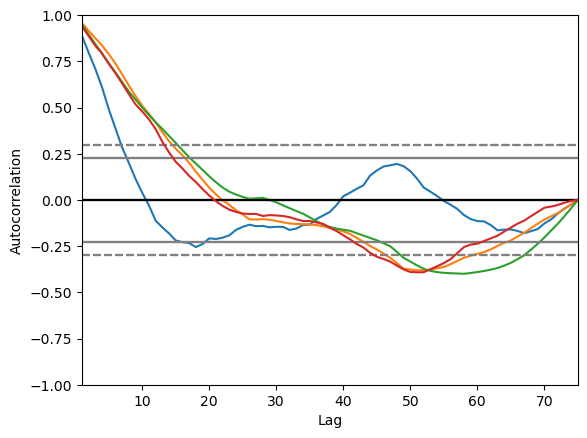

In [120]:
pd.plotting.autocorrelation_plot(df['connor'])
pd.plotting.autocorrelation_plot(df['helio'])
pd.plotting.autocorrelation_plot(df['sam'])
pd.plotting.autocorrelation_plot(df['guest'])

## Trend decomposition
We suspect that a players performance over time is an additive function of some linear trend with noise. We can verify this by taking a trend decomposition of net profit/loss. 

In [121]:
# Calculate Interesting Stats

# 1. Average games per night
games_per_night = df_data.groupby('date')['game_num'].max().mean()
print(f"Avg games per night: {games_per_night:.2f}")

# 2. Dealer Win Rate
dealer_wins = df_data['dealer_win'].dropna()
if dealer_wins.empty:
    dealer_win_rate = 0
else:
    dealer_win_rate = dealer_wins.mean()
print(f"Dealer Win Rate: {dealer_win_rate:.2%}")

# 3. Self Draw Rate
from_wall_counts = df_data['from_wall'].dropna()
if not from_wall_counts.empty:
    self_draw_rate = from_wall_counts.mean()
else:
    self_draw_rate = 0
print(f"Self Draw Rate: {self_draw_rate:.2%}")

# 4. Player Stats (Win Rate, Avg Fan, Points)
player_stats = []
big3 = ['connor','helio','sam']
guests = ['oscar','nick','drew','ruohan','brandon','lixin','alice']
all_players_list = big3 + guests

for p in all_players_list:
    p_data = df_data[p].dropna()
    games_played = len(p_data)
    if games_played > 0:
        wins = p_data[p_data > 0]
        losses = p_data[p_data < 0]
        win_rate = len(wins) / games_played
        
        # Avg Fan when winning
        win_indices = wins.index
        avg_win_fan = df_data.loc[win_indices, 'fan'].mean()
        
        # Avg Points
        avg_win_points = wins.mean() if not wins.empty else 0
        avg_loss_points = losses.mean() if not losses.empty else 0
        
        player_stats.append({
            'Player': p.capitalize(),
            'Games Played': games_played,
            'Win Rate': win_rate,
            'Avg Win Fan': f"{avg_win_fan:.1f}" if not pd.isna(avg_win_fan) else "0.0",
            'Avg Win Points': f"{avg_win_points:.1f}",
            'Avg Loss Points': f"{avg_loss_points:.1f}"
        })

# Guest Aggregate Stats
guest_series_list = [df_data[g].dropna() for g in guests]
guest_data = pd.concat(guest_series_list)
games_played = len(guest_data)
if games_played > 0:
    wins = guest_data[guest_data > 0]
    losses = guest_data[guest_data < 0]
    win_rate = len(wins) / games_played
    
    # Avg Fan (using indices from concatenated series)
    win_indices = wins.index
    avg_win_fan = df_data.loc[win_indices, 'fan'].mean()
    
    avg_win_points = wins.mean() if not wins.empty else 0
    avg_loss_points = losses.mean() if not losses.empty else 0
    
    player_stats.append({
        'Player': 'Guest (aggregate)',
        'Games Played': games_played,
        'Win Rate': win_rate,
        'Avg Win Fan': f"{avg_win_fan:.1f}" if not pd.isna(avg_win_fan) else "0.0",
        'Avg Win Points': f"{avg_win_points:.1f}",
        'Avg Loss Points': f"{avg_loss_points:.1f}"
    })

stats_df = pd.DataFrame(player_stats)
# Sort by Games Played descending
stats_df = stats_df.sort_values(by='Games Played', ascending=False)
# Format Win Rate as percentage for display
stats_df['Win Rate'] = stats_df['Win Rate'].map(lambda x: f"{x:.2%}")
display(stats_df)


Avg games per night: 6.33
Dealer Win Rate: 17.50%
Self Draw Rate: 27.03%


,Player,Games Played,Win Rate,Avg Win Fan,Avg Win Points,Avg Loss Points
0,Connor,74,28.38%,7.5,141.7,-42.0
1,Helio,74,28.38%,9.4,198.9,-38.0
2,Sam,74,8.11%,5.5,109.3,-49.0
10,Guest (aggregate),74,33.78%,4.5,84.8,-53.7
6,Ruohan,23,30.43%,4.0,64.0,-64.0
3,Oscar,12,41.67%,3.6,54.4,-52.6
5,Drew,10,20.00%,7.0,224.0,-50.0
4,Nick,9,55.56%,5.2,92.8,-68.0
7,Brandon,8,12.50%,4.0,64.0,-30.9
8,Lixin,6,50.00%,4.3,74.7,-37.3


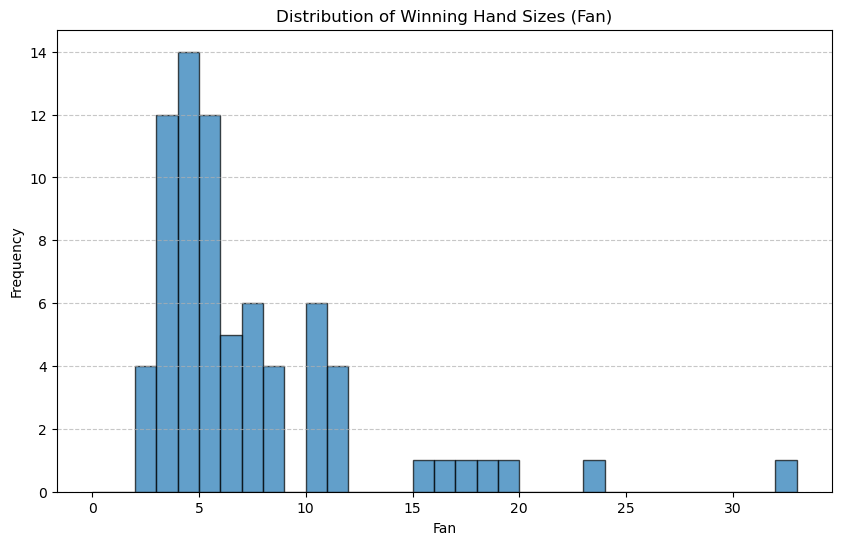

In [122]:
# Histogram of Winning Hand Sizes (Fan)
plt.figure(figsize=(10, 6))
plt.hist(df_data['fan'].dropna(), bins=range(0, int(df_data['fan'].max()) + 2, 1), edgecolor='black', alpha=0.7)
plt.title('Distribution of Winning Hand Sizes (Fan)')
plt.xlabel('Fan')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("fan_distribution.png", bbox_inches='tight')
plt.show()


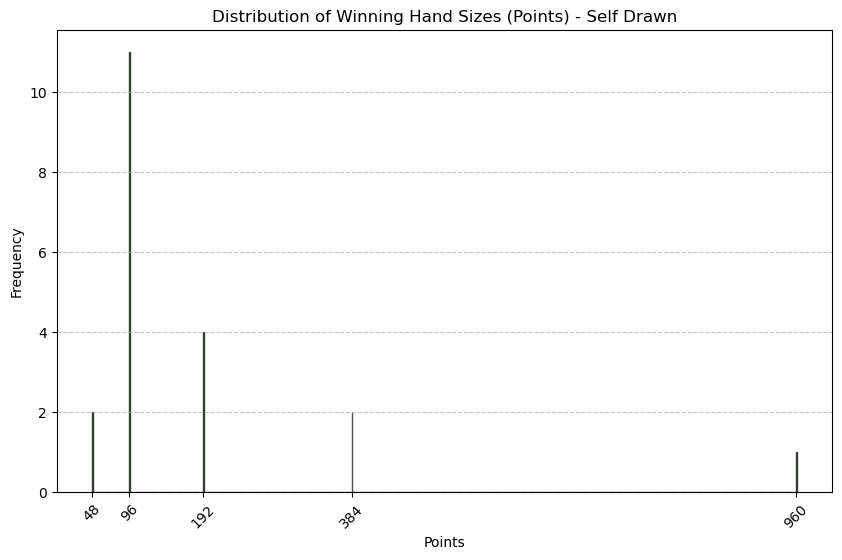

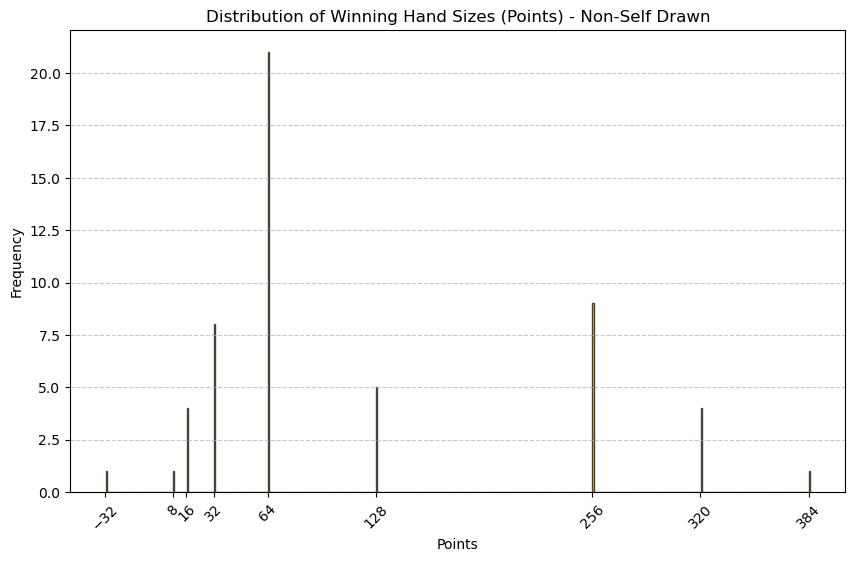

In [123]:
# Histograms of Winning Hand Sizes (Points)

current_big3 = ['connor','helio','sam']
current_guests = ['oscar','nick','drew','ruohan','brandon','lixin','alice']
current_players = current_big3 + current_guests

# Extract winning points (max score in row)
winning_points = df_data[current_players].max(axis=1)

self_drawn_points = winning_points[df_data['from_wall'] == 1]
discard_points = winning_points[df_data['from_wall'] == 0]

# Plot 1: Self-Drawn
plt.figure(figsize=(10, 6))
unique_self_drawn = sorted(self_drawn_points.dropna().unique())
plt.hist(self_drawn_points.dropna(), bins=range(int(self_drawn_points.min()), int(self_drawn_points.max()) + 2, 1), edgecolor='black', alpha=0.7, color='green', rwidth=0.8)
plt.title('Distribution of Winning Hand Sizes (Points) - Self Drawn')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.xticks(unique_self_drawn, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("win_points_self_drawn.png", bbox_inches='tight')
plt.show()

# Plot 2: Non-Self-Drawn
plt.figure(figsize=(10, 6))
unique_discard = sorted(discard_points.dropna().unique())
plt.hist(discard_points.dropna(), bins=range(int(discard_points.min()), int(discard_points.max()) + 2, 1), edgecolor='black', alpha=0.7, color='orange', rwidth=0.8)
plt.title('Distribution of Winning Hand Sizes (Points) - Non-Self Drawn')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.xticks(unique_discard, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("win_points_non_self_drawn.png", bbox_inches='tight')
plt.show()


In [124]:
# Top 3 Largest Hands

hand_data = []

for index, row in df_data.iterrows():
    # Fan
    fan = row['fan']
    if pd.isna(fan):
        continue
    
    # Points (Winner's score)
    scores = row[current_players]
    points = scores.max()
    
    if pd.isna(points) or points <= 0:
        continue

    # Identify Player
    # idxmax returns the index (player name) of the max value
    winner = scores.idxmax()

    # Self Drawn?
    is_self_drawn = "Yes" if row['from_wall'] == 1 else "No"
    
    hand_data.append({
        'Date': row['date'],
        'Player': winner.capitalize(),
        'Fan': int(fan),
        'Points': int(points),
        'Self Drawn': is_self_drawn
    })

hands_df = pd.DataFrame(hand_data)
hands_df = hands_df.sort_values(by=['Fan', 'Points'], ascending=[False, False])
top_3 = hands_df.head(3)

display(top_3)


,Date,Player,Fan,Points,Self Drawn
24,10/3/2025,Helio,32,960,Yes
60,1/28/2026,Helio,23,256,No
56,12/12/2025,Connor,19,320,No


In [125]:
#Convert to Readme